In [1]:
#RNN
#We will use the epoch as 1 and a batch size of 64 samples at a time to establish the connection between the input and the output.
#The new representations are passed to LSTM cells, which go to a sigmoid output layer.

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(1)    # reproducible

In [6]:
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = False   # set to True if haven't download the data

In [7]:
'''
The RNN models have hyperparameters, such as the number of iterations (EPOCH);
    batch size dependent on the memory available in a single machine;
    a time step to remember the sequence of information;
    input size, which shows the vector size;
    and learning rate.

The selection of these values is indicative;we cannot depend on them for other use cases.

The value selection for hyperparameter tuning is an iterative process;
    either you can choose multiple parameters and decide which one is working,
    or do parallel training of the model and decide which one is working fine.
'''

'\nThe RNN models have hyperparameters, such as the number of iterations (EPOCH);\n    batch size dependent on the memory available in a single machine;\n    a time step to remember the sequence of information;\n    input size, which shows the vector size;\n    and learning rate.\n\nThe selection of these values is indicative;we cannot depend on them for other use cases.\n\nThe value selection for hyperparameter tuning is an iterative process;\n    either you can choose multiple parameters and decide which one is working,\n    or do parallel training of the model and decide which one is working fine.\n'

In [9]:
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


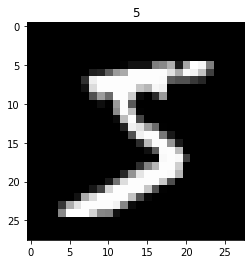

In [10]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [12]:
'''
To train the deep learning model, 
    we need to convert the whole training dataset into mini batches,
    which help us with averaging the final accuracy of the model.

By using the data loader function, 
    we can load the training data and prepare the mini batches.
    
The purpose of the shuffle selection in mini batches is to ensure that the model captures all the variations in the actual dataset.
'''

'\nTo train the deep learning model, \n    we need to convert the whole training dataset into mini batches,\n    which help us with averaging the final accuracy of the model.\n\nBy using the data loader function, \n    we can load the training data and prepare the mini batches.\n    \nThe purpose of the shuffle selection in mini batches is to ensure that the model captures all the variations in the actual dataset.\n'

In [11]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   
# shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\andy\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
'''
The test data is captured with the flag train=False

It is transformed to a tensor using the test data random sample of 2000 each at a time is picked up for testing the model.

The test features set is converted to a variable format and the test label vector is represented in a NumPy array format.
'''

'\nThe test data is captured with the flag train=False\n\nIt is transformed to a tensor using the test data random sample of 2000 each at a time is picked up for testing the model.\n\nThe test features set is converted to a variable format and the test label vector is represented in a NumPy array format.\n'

In [17]:
'''
nn.LSTM:
    input_size：x的特征维度
    hidden_size：隐藏层的特征维度
    num_layers：lstm隐层的层数，默认为1
    bias：False则bih=0和bhh=0. 默认为True
    batch_first：True则输入输出的数据格式为 (batch, seq, feature)
    dropout：除最后一层，每一层的输出都进行dropout，默认为: 0
    bidirectional：True则为双向lstm默认为False
    输入：input, (h0, c0)
    输出：output, (hn,cn)
    
batch_first True 或者 False，
    因为nn.lstm()接受的数据输入是(序列长度，batch，输入维数)，
    这和我们cnn输入的方式不太一致，
    所以使用batch_first，
    我们可以将输入变成(batch，序列长度，输入维数)
    
    
In the LSTM network, 
    the image width is considered the input size, 
    hidden size is decided as the number of neurons in the hidden layer,
    num_layers shows the number of RNN layers in the network.
'''

'\nnn.LSTM:\n    input_size：x的特征维度\n    hidden_size：隐藏层的特征维度\n    num_layers：lstm隐层的层数，默认为1\n    bias：False则bih=0和bhh=0. 默认为True\n    batch_first：True则输入输出的数据格式为 (batch, seq, feature)\n    dropout：除最后一层，每一层的输出都进行dropout，默认为: 0\n    bidirectional：True则为双向lstm默认为False\n    输入：input, (h0, c0)\n    输出：output, (hn,cn)\n    \nbatch_first True 或者 False，\n    因为nn.lstm()接受的数据输入是(序列长度，batch，输入维数)，\n    这和我们cnn输入的方式不太一致，\n    所以使用batch_first，\n    我们可以将输入变成(batch，序列长度，输入维数)\n    \n    \nIn the LSTM network, \n    the image width is considered the input size, \n    hidden size is decided as the number of neurons in the hidden layer,\n    num_layers shows the number of RNN layers in the network.\n'

In [18]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [19]:
'''
The RNN module, 
    within the LSTM module, 
    produces the output as a vector size of 64×10 
    because the output layer has digits to be classified as 0 to 9. 

The last forward function shows how to proceed with forward propagation in an RNN network.


The following script shows how the LSTM model is processed under the RNN class.

In the LSTM function,
    we pass the input length as 28 and the number of neurons in the hidden layer as 64,
    and from the hidden 64 neurons to the output 10 neurons.
'''

'\nThe RNN module, \n    within the LSTM module, \n    produces the output as a vector size of 64×10 \n    because the output layer has digits to be classified as 0 to 9. \n\nThe last forward function shows how to proceed with forward propagation in an RNN network.\n\n\nThe following script shows how the LSTM model is processed under the RNN class.\n\nIn the LSTM function,\n    we pass the input length as 28 and the number of neurons in the hidden layer as 64,\n    and from the hidden 64 neurons to the output 10 neurons.\n'

In [20]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [22]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

In [23]:
'''
To optimize all RNN parameters, we use the Adam optimizer. 

Inside the function, we use the learning rate as well. 

The loss function used in this example is the cross-entropy loss function.

We need to provide multiple epochs to get the best parameters.

In the following script, we are printing the training loss and the test accuracy.

After one epoch, the test accuracy increases to 95% and the training loss reduces to 0.24.
'''

'\nTo optimize all RNN parameters, we use the Adam optimizer. \n\nInside the function, we use the learning rate as well. \n\nThe loss function used in this example is the cross-entropy loss function.\n\nWe need to provide multiple epochs to get the best parameters.\n\nIn the following script, we are printing the training loss and the test accuracy.\n\nAfter one epoch, the test accuracy increases to 95% and the training loss reduces to 0.24.\n'

In [25]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3067 | test accuracy: 0.09
Epoch:  0 | train loss: 1.0397 | test accuracy: 0.53
Epoch:  0 | train loss: 0.7419 | test accuracy: 0.71
Epoch:  0 | train loss: 0.6746 | test accuracy: 0.82
Epoch:  0 | train loss: 0.4165 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3237 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3108 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3215 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1739 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1667 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3887 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1921 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0342 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1600 | test accuracy: 0.95
Epoch:  0 | train loss: 0.4143 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0627 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2688 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0910 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1092 | test accuracy

In [27]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


# Recipe 3-9. Implementing a RNN for Regression Problems

In [28]:
##RNN Regressor

In [29]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
torch.manual_seed(1)    # reproducible

In [31]:
# Hyper Parameters
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

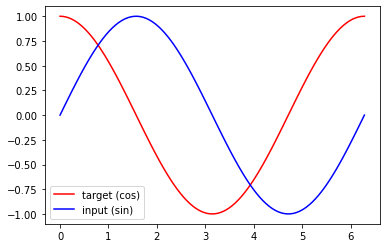

In [32]:
# show data
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()


# Recipe 3-10. Using PyTorch Built-in Functions

In [33]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. 
            #(batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

In [34]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [36]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()

In [37]:
h_state = None      # for initial hidden state

In [38]:
plt.figure(1, figsize=(12, 5))
plt.ion()           # continuously plot

<Figure size 864x360 with 0 Axes>

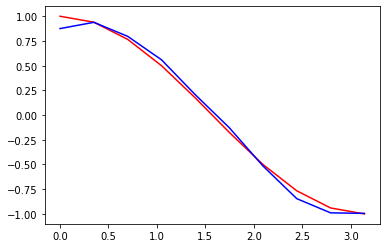

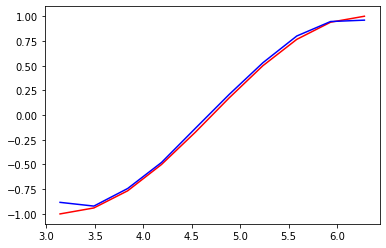

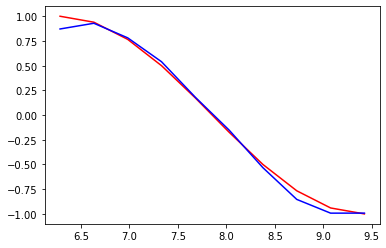

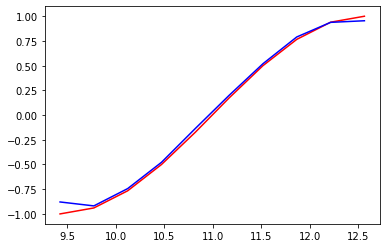

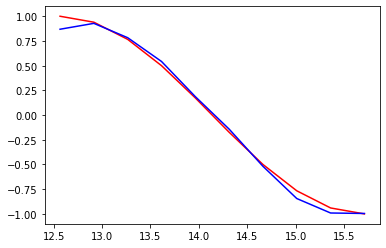

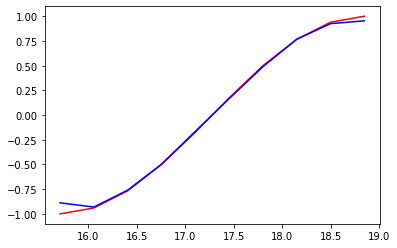

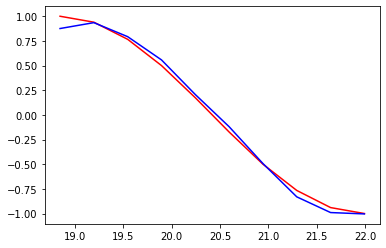

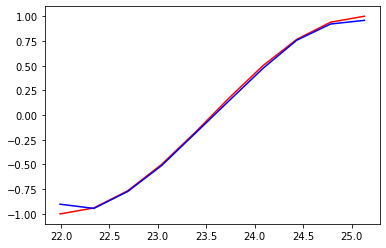

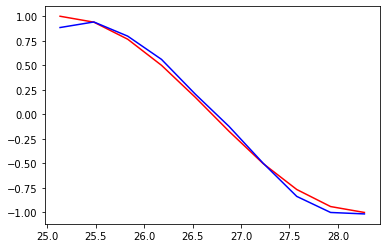

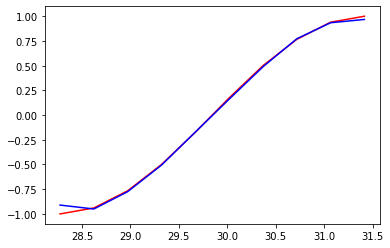

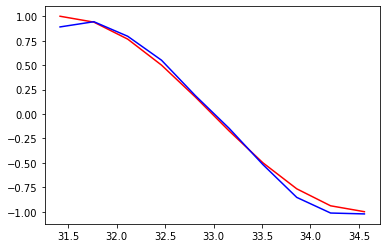

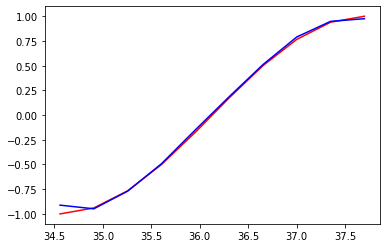

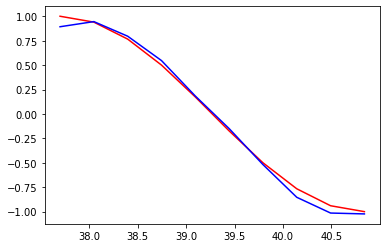

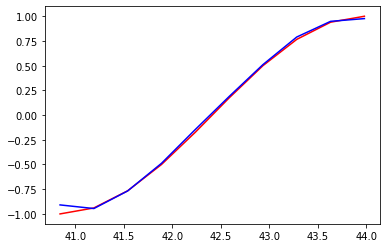

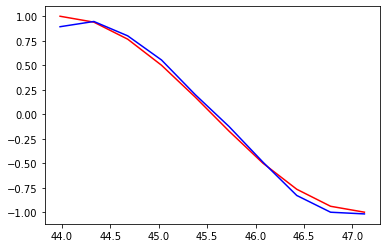

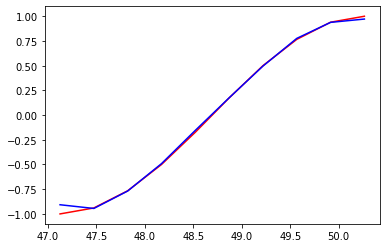

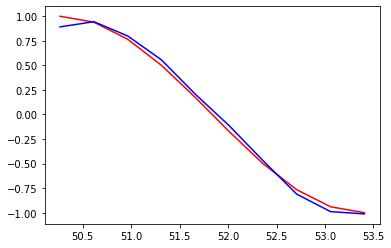

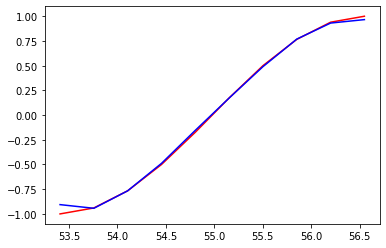

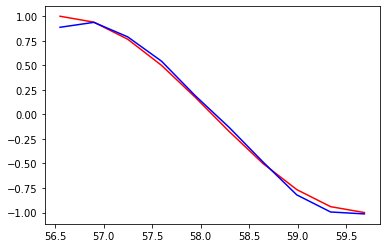

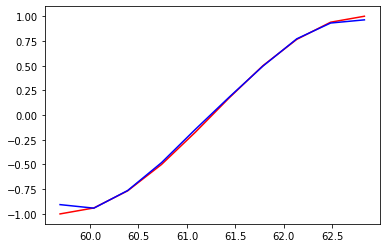

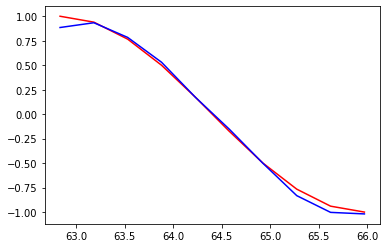

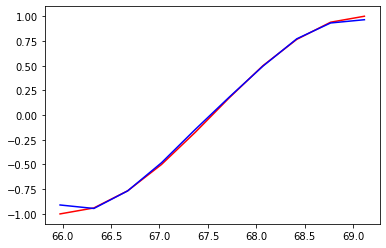

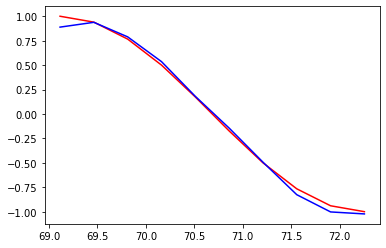

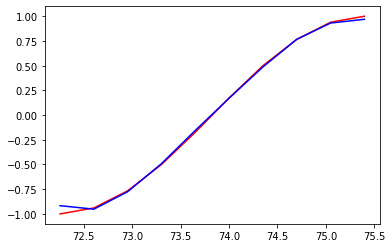

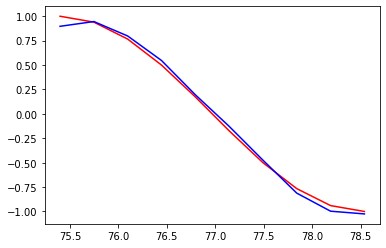

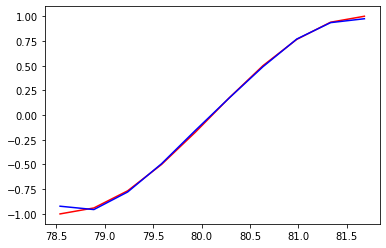

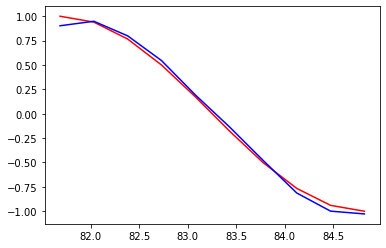

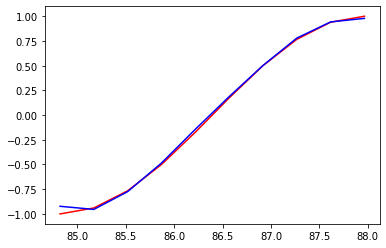

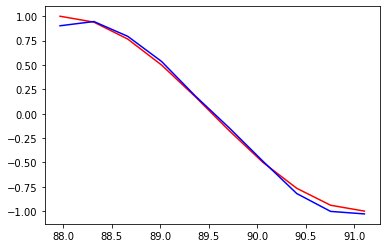

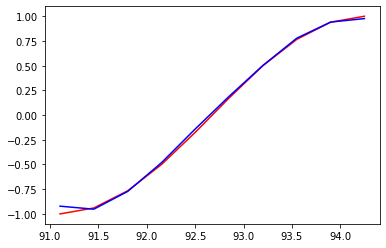

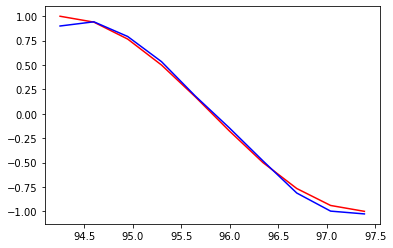

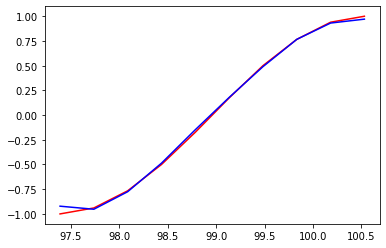

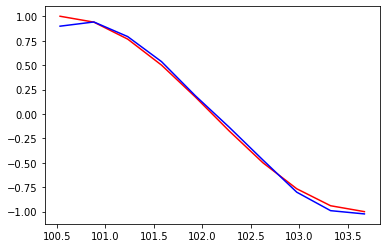

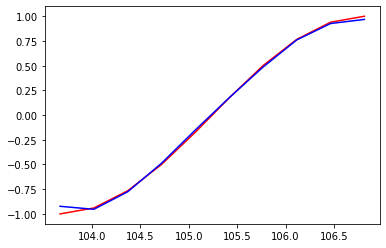

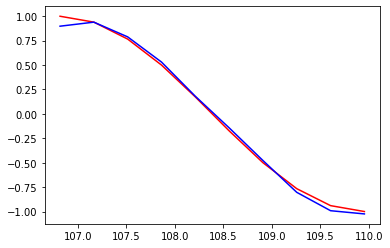

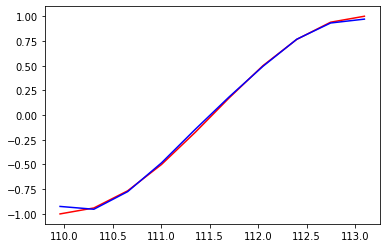

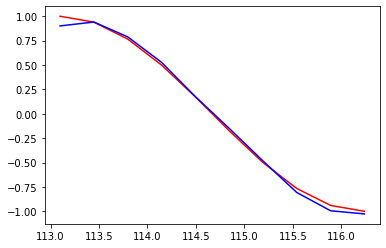

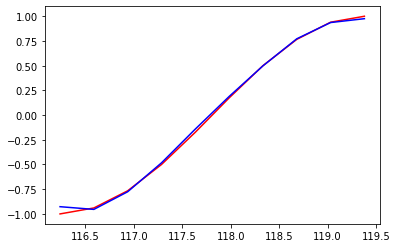

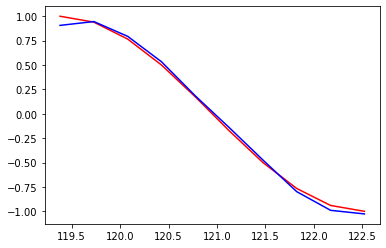

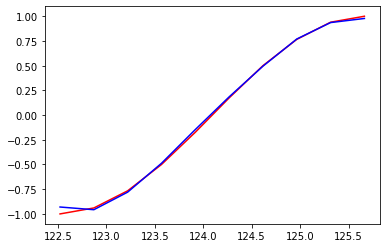

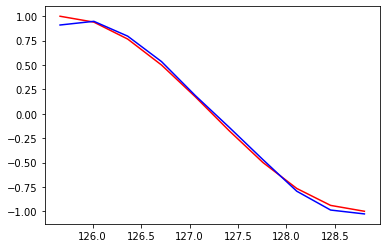

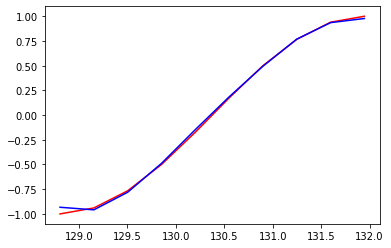

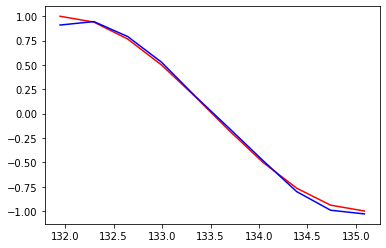

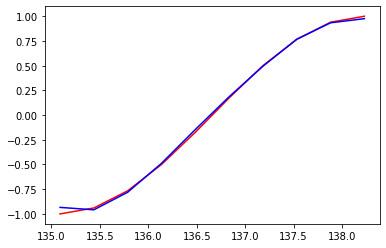

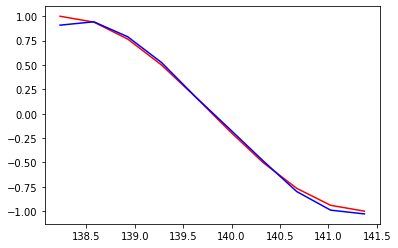

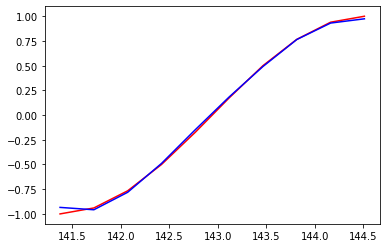

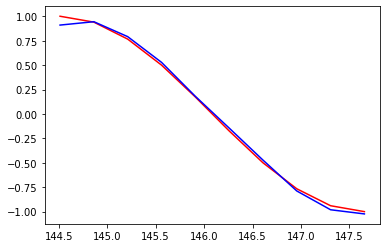

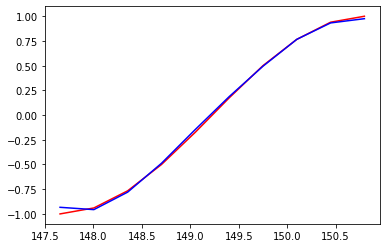

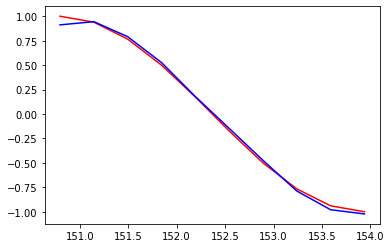

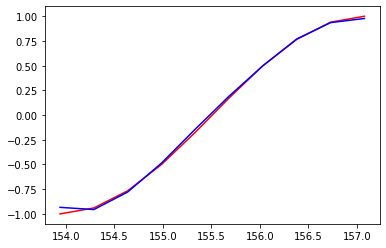

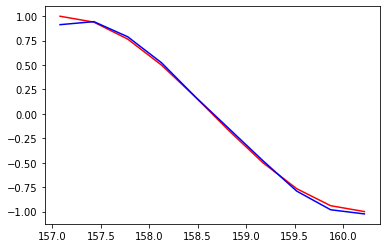

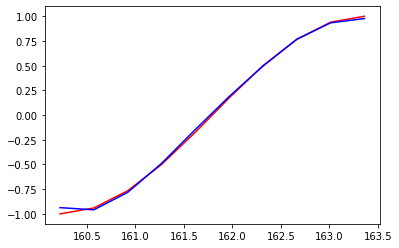

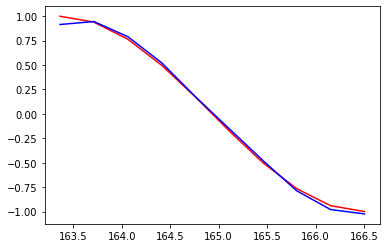

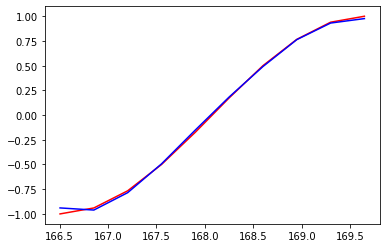

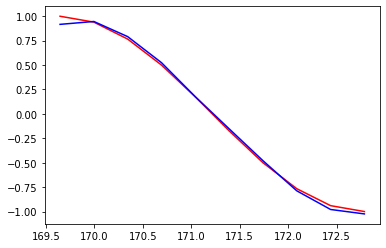

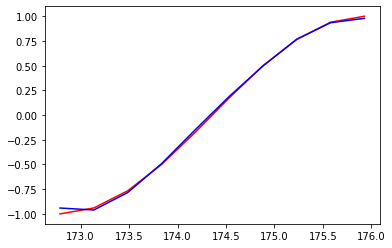

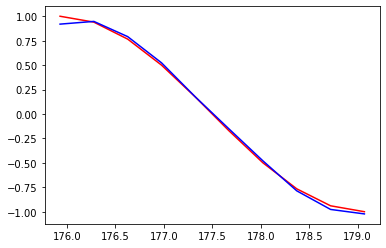

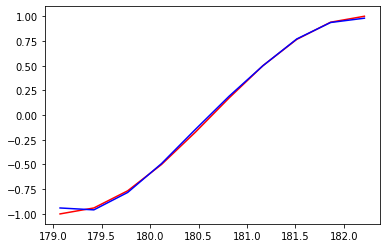

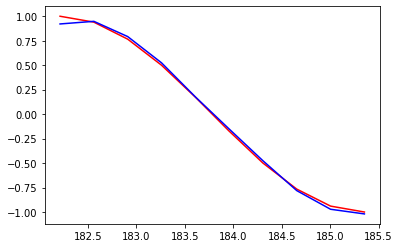

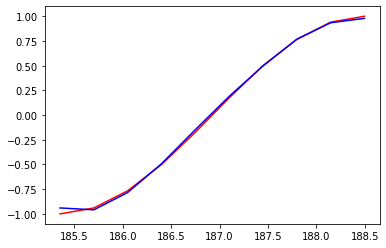

In [41]:
for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi   # time range
    # use sin predicts cos
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)    # float32 for converting torch FloatTensor
    y_np = np.cos(steps)

    x = Variable(torch.from_numpy(x_np[np.newaxis, :, np.newaxis]))    
    # shape (batch, time_step, input_size)
    y = Variable(torch.from_numpy(y_np[np.newaxis, :, np.newaxis]))

    prediction, h_state = rnn(x, h_state)   # rnn output
    # !! next step is important !!
    h_state = Variable(h_state.data)   
    # repack the hidden state, break the connection from last iteration

    loss = loss_func(prediction, y)         # cross entropy loss
    optimizer.zero_grad()                   # clear gradients for this training step
    loss.backward()                         # backpropagation, compute gradients
    optimizer.step()                        # apply gradients

    # plotting
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw(); plt.pause(0.05)